In [1]:
class Convolution:
    def __init__(self, W, b, stride = 1, pad = 0):
        self.W = W    # 가중치(필터)
        self.b = b    # 편향
        self.stride = stride    # 스트라이드
        self.pad = pad    #패딩

        # 중간 데이터 저장용
        # backward (역전파)에서 사용
        self.x = None    # 입력 데이터
        self.col = None    # im2col 거친 결과 (2차원 배열)
        self.col_W = None    # im2col 거친 결과에 대한 가중치 (필터)
        self.dW = None    # 가중치 기울기
        self.db = None    # 편향 기울기
        
        
    def forward(self, x):
        FN, C, FH, FW = self.W.shape    # 필터갯수, 채널, 필터높이, 필터너비의 4차원 형상
        N, C, H, W = x.shape    # 입력 데이터의 4차원 형상

        out_h = (H + 2 * self.pad - FW) // self.stride + 1
        out_w = (W + 2 * self.pad - FW) // self.stride + 1

        # 필터 전개
        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T

        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W
        
        return out
    
    
    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0, 2, 3, 1).reshape(-1, FN)    # (N, C, H, W)를 (N, H, W, C)로 변경

        self.db = np.sum(dout, axis = 0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx

    
    

In [2]:
def im2col(input_data, filter_h, filter_w, stride = 1, pad = 0):
        N, C, H, W = input_data.shape
        out_h = (H + 2 * pad - filter_h) // stride + 1
        out_w = (W + 2 * pad - filter_w) // stride + 1

        img = np.pad(input_data, [(0, 0), (0, 0), (pad, pad), (pad, pad)])
        col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

        for y in range(filter_h):
            y_max = y + stride * out_h

            for x in range(filter_w):
                x_max = x + stride * out_w
                col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

        col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N * out_h * out_w, -1)

        return col

In [3]:
import numpy as np

window_h = 3
window_w = 3
x1 = np.random.rand(1, 3, 4, 4)

col1 = im2col(x1, window_h, window_w, stride = 1, pad = 0)
print("x1.shape : ", x1.shape)
print("col1.shape : ", col1.shape)

col1 = col1.reshape(-1, window_h * window_w)
print("col1 reshape 후 shape : ", col1.shape)
print(" ")

###########

x2 = np.random.rand(2, 1, 5, 5)

col2 = im2col(x2, window_h, window_w, stride = 1, pad = 0)
print("x2.shape : ", x2.shape)
print("col2.shape : ", col2.shape)

col2 = col2.reshape(-1, window_h * window_w)
print("col2 reshape 후 shape : ", col2.shape)
print(" ")

x1.shape :  (1, 3, 4, 4)
col1.shape :  (4, 27)
col1 reshape 후 shape :  (12, 9)
 
x2.shape :  (2, 1, 5, 5)
col2.shape :  (18, 9)
col2 reshape 후 shape :  (18, 9)
 


In [4]:
pad = 3
array_2d = np.array([[1, 2, 3],
                     [4, 5, 6]])

print("패딩이 적용되기 전 array_2d : ", array_2d, sep = '\n')
print(" ")

pad_array_2d = np.pad(array_2d, ((pad, pad), (pad, pad)))
print("3 패딩이 적용된 array_2d : ", pad_array_2d, sep = "\n")

패딩이 적용되기 전 array_2d : 
[[1 2 3]
 [4 5 6]]
 
3 패딩이 적용된 array_2d : 
[[0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 1 2 3 0 0 0]
 [0 0 0 4 5 6 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]


In [5]:
pad = 2
bw_img_data = np.array([[[[1, 2, 3, 0],
                         [0, 1, 2, 3],
                         [3, 0, 1, 2],
                         [2, 3, 0, 1]]]])
print("데이터 : ", bw_img_data, sep = "\n")
print("데이터 shape : ", bw_img_data.shape)

pad_bw_img_data = np.pad(bw_img_data, [(0, 0), (0, 0), (pad, pad), (pad, pad)])
print(" ")

print("2 패딩이 적용된 데이터 : ", pad_bw_img_data, sep = "\n")
print("2 패딩이 적용된 데이터 shape : ", pad_bw_img_data.shape)

데이터 : 
[[[[1 2 3 0]
   [0 1 2 3]
   [3 0 1 2]
   [2 3 0 1]]]]
데이터 shape :  (1, 1, 4, 4)
 
2 패딩이 적용된 데이터 : 
[[[[0 0 0 0 0 0 0 0]
   [0 0 0 0 0 0 0 0]
   [0 0 1 2 3 0 0 0]
   [0 0 0 1 2 3 0 0]
   [0 0 3 0 1 2 0 0]
   [0 0 2 3 0 1 0 0]
   [0 0 0 0 0 0 0 0]
   [0 0 0 0 0 0 0 0]]]]
2 패딩이 적용된 데이터 shape :  (1, 1, 8, 8)


In [6]:
pad = 1
img_data = np.random.rand(1, 3, 4, 4)

print("정규화된 데이터 : ", img_data, sep = "\n")
print("정규화된 데이터 shape : ", img_data.shape)

pad_img_data = np.pad(img_data, [(0, 0), (0, 0), (pad, pad), (pad, pad)])
print(" ")

print("1 패딩이 적용된 데이터 : ", pad_img_data, sep = "\n")
print("1 패딩이 적용된 데이터 shape : ", pad_img_data.shape)

정규화된 데이터 : 
[[[[0.4892603  0.44990055 0.89821262 0.12143417]
   [0.2219359  0.13457902 0.00338339 0.28069381]
   [0.27001857 0.04201192 0.15441816 0.77426738]
   [0.62395898 0.67385899 0.40408967 0.87088527]]

  [[0.96395218 0.72542636 0.95804876 0.93764257]
   [0.08368406 0.44722499 0.37950501 0.76910962]
   [0.87342386 0.45792028 0.57583599 0.80522377]
   [0.38787859 0.50240237 0.98994112 0.18434907]]

  [[0.94139021 0.09809791 0.59680109 0.5246577 ]
   [0.39852611 0.65724175 0.27954118 0.1517592 ]
   [0.27634104 0.58419277 0.11305147 0.58014011]
   [0.23955508 0.25808748 0.97692292 0.94176851]]]]
정규화된 데이터 shape :  (1, 3, 4, 4)
 
1 패딩이 적용된 데이터 : 
[[[[0.         0.         0.         0.         0.         0.        ]
   [0.         0.4892603  0.44990055 0.89821262 0.12143417 0.        ]
   [0.         0.2219359  0.13457902 0.00338339 0.28069381 0.        ]
   [0.         0.27001857 0.04201192 0.15441816 0.77426738 0.        ]
   [0.         0.62395898 0.67385899 0.40408967 0.87088527 

In [7]:
def col2im(col, input_shape, filter_h, filter_w, stride = 1, pad = 0):
    N, C, H, W = input_shape
    out_h = (H + 2 * pad - filter_h) // stride + 1
    out_w = (W + 2 * pad - filter_w) // stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2 * pad + stride - 1, W + 2 * pad + stride - 1))

    for y in range(filter_h):
        y_max = y + stride * out_h

        for x in range(filter_w):
            x_max = x + stride * out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

In [8]:
class ReLU:
    def __inint__(self):
        self.boolean_array = None
        
    def forward(self, x):
        self.boolean_array = (x <= 0)
        out = x.copy()
        out[self.boolean_array] = 0
        
        return out
    
    def backward(self, dout):
        dout[self.boolean_array] = 0
        dx = dout
        
        return dx

In [9]:
x = np.array([[1.0, -1.5],
             [-4.0, 6.0]])

boolean_array = (x <= 0)
print(boolean_array)

[[False  True]
 [ True False]]


In [10]:
out = x.copy()
print("out : ", out, sep = "\n")

out : 
[[ 1.  -1.5]
 [-4.   6. ]]


In [11]:
print("out[boolean_array] : ", out[boolean_array])

out[boolean_array] = 0
print("out : ", out, sep = "\n")

out[boolean_array] :  [-1.5 -4. ]
out : 
[[1. 0.]
 [0. 6.]]


In [12]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride = 1, pad = 0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None
        
    def forward(self, x):
        N, C, H, W = x.shape
        out_h = (H - self.pool_h) // self.stride + 1
        out_w = (W - self.pool_w) // self.stride + 1

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h * self.pool_w)
        
        arg_max = np.argmax(col, axis = 1)
        out = np.max(col, axis = 1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
        
        self.x = x
        self.arg_max = arg_max
        
        return out
    
    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)

        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,))

        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)

        return dx

In [13]:
pool_h = 2
pool_w = 2
stride = 2
pad = 0

x = np.arange(32)
x = x.reshape(2, 1, 4, 4)

print("맨 처음 데이터 : ", x, sep = "\n")
print("맨 처음 데이터 shape : ", x.shape)
print(" ")

# im2col 사용해 4차원 데이터를 2차원 데이터 행렬로 변경
im2col_x = im2col(x, pool_h, pool_w, stride, pad)
print("im2col 적용 후 데이터 : ", im2col_x, sep = "\n")
print("맨 처음 데이터 shape : ", im2col_x.shape)
print(" ")

im2col_x = im2col_x.reshape(-1, pool_h * pool_w)
print("reshape 후 데이터 : ", im2col_x, sep = "\n")
print(" ")

print("reshape 후 데이터 shape : ", im2col_x.shape)

맨 처음 데이터 : 
[[[[ 0  1  2  3]
   [ 4  5  6  7]
   [ 8  9 10 11]
   [12 13 14 15]]]


 [[[16 17 18 19]
   [20 21 22 23]
   [24 25 26 27]
   [28 29 30 31]]]]
맨 처음 데이터 shape :  (2, 1, 4, 4)
 
im2col 적용 후 데이터 : 
[[ 0.  1.  4.  5.]
 [ 2.  3.  6.  7.]
 [ 8.  9. 12. 13.]
 [10. 11. 14. 15.]
 [16. 17. 20. 21.]
 [18. 19. 22. 23.]
 [24. 25. 28. 29.]
 [26. 27. 30. 31.]]
맨 처음 데이터 shape :  (8, 4)
 
reshape 후 데이터 : 
[[ 0.  1.  4.  5.]
 [ 2.  3.  6.  7.]
 [ 8.  9. 12. 13.]
 [10. 11. 14. 15.]
 [16. 17. 20. 21.]
 [18. 19. 22. 23.]
 [24. 25. 28. 29.]
 [26. 27. 30. 31.]]
 
reshape 후 데이터 shape :  (8, 4)


In [14]:
arg_max = np.argmax(im2col_x, axis = 1)
out_max = np.max(im2col_x, axis = 1)

print("axis = 1을 적용한 최대 index : ", arg_max)
print("axis = 1을 적용한 최대 값 : ", out_max)

axis = 1을 적용한 최대 index :  [3 3 3 3 3 3 3 3]
axis = 1을 적용한 최대 값 :  [ 5.  7. 13. 15. 21. 23. 29. 31.]


In [15]:
arg_max = np.argmax(im2col_x)
out_max = np.max(im2col_x)

print("axis = 1을 적용하지 않은 최대 index : ", arg_max)
print("axis = 1을 적용하지 않은 최대 값 : ", out_max)

axis = 1을 적용하지 않은 최대 index :  31
axis = 1을 적용하지 않은 최대 값 :  31.0


In [16]:
## 전체
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from common.layers import *
from dataset.mnist import load_mnist

class CNN:
    def __init__(self, input_dim = (1, 28, 28),
                conv_param = {"filter_num" : 30, "filter_size" : 5, "pad" : 0, "stride" : 1},
                hidden_size = 100, output_size = 10, weight_init_std = 0.01):
        
        filter_num = conv_param["filter_num"]
        filter_size = conv_param["filter_size"]
        filter_pad = conv_param["pad"]
        filter_stride = conv_param["stride"]
        
        input_size = input_dim[1]
        
        conv_output_size = (input_size - filter_size + 2 * filter_pad) // filter_stride + 1
        pool_output_size = filter_num * (conv_output_size // 2) * (conv_output_size // 2)
        
        # 가중치 초기화
        self.params = {}
        self.params["W1"] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params["b1"] = np.zeros(filter_num)
        
        
        self.params["W2"] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params["b2"] = np.zeros(hidden_size)
        
        
        self.params["W3"] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params["b3"] = np.zeros(output_size)
        
        # 계층 생성
        self.layers = OrderedDict()
        self.layers["Conv1"] = Convolution(self.params["W1"], self.params["b1"],
                                         conv_param["stride"], conv_param["pad"])

        self.layers["ReLU1"] = ReLU()
        self.layers["Pool1"] = Pooling(pool_h = 2, pool_w = 2, stride = 2)
        self.layers["Affine1"] = Affine(self.params["W2"], self.params['b2'])
        self.layers["ReLU2"] = ReLU()
        self.layers["Affine2"] = Affine(self.params["W3"], self.params["b3"])

        self.lastLayer = SoftmaxWithLoss()
        
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x


    # x : 입력데이터, y : 예측값, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)


    def accuracy (self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis = 1)

        if t.ndim != 1:
            t = np.argmax(t, axis = 1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy


    def gradient(self, x, t):
        # 순전파
        self.loss(x, t)

        # 역전파
        dout = 1
        dout = self.lastLayer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()

        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads["W1"], grads["b1"] = self.layers["Conv1"].dW, self.layers["Conv1"].db
        grads["W2"], grads["b2"] = self.layers["Affine1"].dW, self.layers["Affine1"].db
        grads["W3"], grads["b3"] = self.layers["Affine2"].dW, self.layers["Affine2"].db

        return grads

In [17]:
import numpy as np
from dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize= True, one_hot_label=True, flatten = False)

x_train = x_train[:5000]
t_train = t_train[:5000]

x_test = x_test[:1000]
t_test = t_test[:1000]

print("x_train : ", np.shape(x_train))
print("t_train : ", np.shape(t_train))

print("x_test : ", np.shape(x_test))
print("t_test : ", np.shape(t_test))

network = CNN()

iters_num = 2000
train_size = x_train.shape[0]
batch_size = 50
learning_rate = 0.1

train_loss_list = []
train_loss_list2 = []
train_acc_list = []
test_acc_list = []

epoch = 0

x_train :  (5000, 1, 28, 28)
t_train :  (5000, 10)
x_test :  (1000, 1, 28, 28)
t_test :  (1000, 10)


In [18]:
iter_per_epoch = train_size // batch_size

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 오차 역전파 이용해 기울기 계산
    grad = network.gradient(x_batch, t_batch)
    
    # 매개변수 갱신
    for key in ("W1", "b1", "W2", "b2", "W3", "b3"):
        network.params[key] -= learning_rate * grad[key]
        
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
        
        
    # 1 epoch 당 정확도 계산
    if i % iter_per_epoch == 0:
        epoch += 1
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
        train_loss_list2.append(loss)
        
        print("Epoch : ", epoch, "=> train 정확도 : ", round(train_acc * 100, 2),
             "% /  test 정확도 : ", round(test_acc * 100, 2),
             "% / loss : ", round(loss, 4))

print("종료")

Epoch :  1 => train 정확도 :  9.9 % /  test 정확도 :  9.4 % / loss :  2.3017
Epoch :  2 => train 정확도 :  20.62 % /  test 정확도 :  21.5 % / loss :  2.276
Epoch :  3 => train 정확도 :  77.64 % /  test 정확도 :  74.9 % / loss :  0.2917
Epoch :  4 => train 정확도 :  88.4 % /  test 정확도 :  85.1 % / loss :  0.2207
Epoch :  5 => train 정확도 :  91.48 % /  test 정확도 :  89.3 % / loss :  0.1203
Epoch :  6 => train 정확도 :  93.22 % /  test 정확도 :  89.1 % / loss :  0.1051
Epoch :  7 => train 정확도 :  94.6 % /  test 정확도 :  90.8 % / loss :  0.0437
Epoch :  8 => train 정확도 :  96.22 % /  test 정확도 :  92.3 % / loss :  0.055
Epoch :  9 => train 정확도 :  96.22 % /  test 정확도 :  92.0 % / loss :  0.0418
Epoch :  10 => train 정확도 :  96.72 % /  test 정확도 :  92.6 % / loss :  0.0263
Epoch :  11 => train 정확도 :  96.38 % /  test 정확도 :  92.4 % / loss :  0.0618
Epoch :  12 => train 정확도 :  97.64 % /  test 정확도 :  93.6 % / loss :  0.0089
Epoch :  13 => train 정확도 :  97.26 % /  test 정확도 :  93.9 % / loss :  0.0155
Epoch :  14 => train 정확도 :  98.22 % /  te

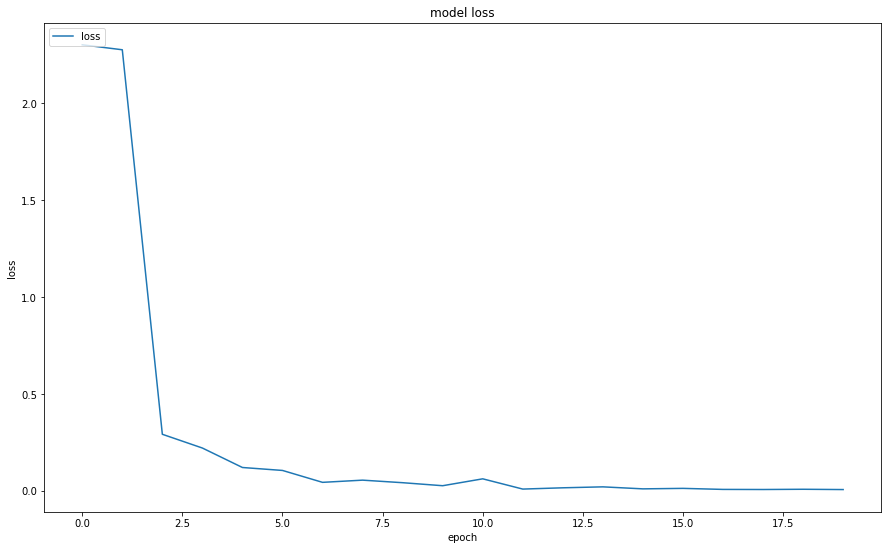

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 9))
plt.plot(train_loss_list2)
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["loss"], loc ="upper left")
plt.show()

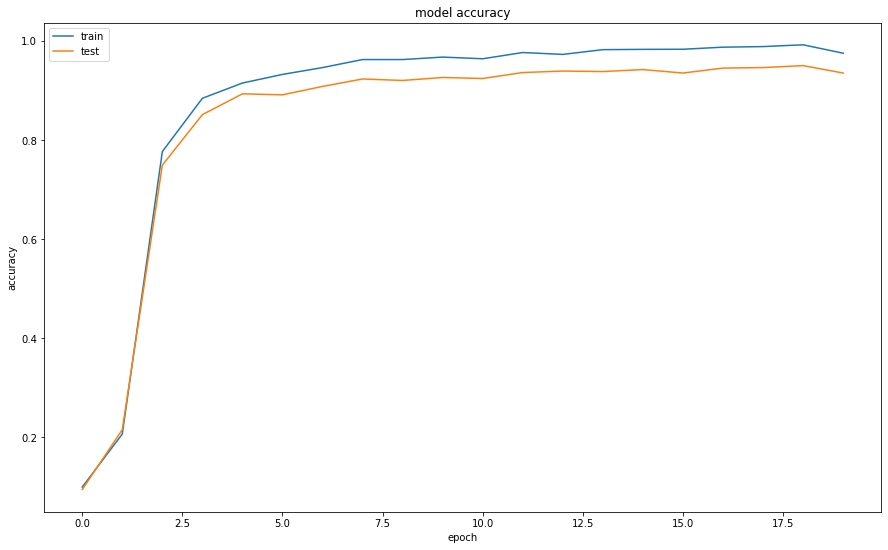

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 9))
plt.plot(train_acc_list)
plt.plot(test_acc_list)
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc ="upper left")
plt.show()